# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import VotingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.base import clone
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
import albumentations as A
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import polars as pl
import warnings
import h5py
import torch
import random
import timm
import io
import os
import shutil
import optuna
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    test_img_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5'
    train_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
    test_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'
    sample_sub_path = '/kaggle/input/isic-2024-challenge/sample_submission.csv'
    checkpoint_path = '/kaggle/input/skin-cancer-detection-resnet50-training/checkpoints/'

    checkpoints = [
        'fold_0_epoch_22_pauc_0.162757.pth',
        'fold_1_epoch_11_pauc_0.12434.pth',
        'fold_2_epoch_28_pauc_0.145016.pth',
        'fold_3_epoch_23_pauc_0.139627.pth',
        'fold_4_epoch_18_pauc_0.128277.pth',
        'fold_5_epoch_48_pauc_0.140243.pth'
    ]
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    val_batch_size = 64
    model_name = "resnet50"
    target = 'target'
    n_folds = 6
    seed = 3

# Loading and processing the datasets

In [3]:
# Reference: https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data
num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 
    'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 
    'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 
    'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 
    'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'
]

new_num_cols = [
    'lesion_size_ratio', 'lesion_shape_index', 'hue_contrast', 'luminance_contrast', 
    'lesion_color_difference', 'border_complexity', 'color_uniformity', 
    'position_distance_3d', 'perimeter_to_area_ratio', 'area_to_perimeter_ratio', 
    'lesion_visibility_score', 'symmetry_border_consistency', 'consistency_symmetry_border', 
    'color_consistency', 'consistency_color', 'size_age_interaction', 
    'hue_color_std_interaction', 'lesion_severity_index', 'shape_complexity_index', 
    'color_contrast_index', 'log_lesion_area', 'normalized_lesion_size', 
    'mean_hue_difference', 'std_dev_contrast', 'color_shape_composite_index', 
    'lesion_orientation_3d', 'overall_color_difference', 'symmetry_perimeter_interaction', 
    'comprehensive_lesion_index', 'color_variance_ratio', 'border_color_interaction', 
    'border_color_interaction_2', 'size_color_contrast_ratio', 'age_normalized_nevi_confidence', 
    'age_normalized_nevi_confidence_2', 'color_asymmetry_index', 'volume_approximation_3d', 
    'color_range', 'shape_color_consistency', 'border_length_ratio', 
    'age_size_symmetry_index', 'index_age_size_symmetry'
]

cat_cols = [
    'sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 
    'tbp_lv_location_simple', 'attribution'
]

norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient']
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

In [4]:
# Reference: https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()),
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + 1e-5),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + 1e-5)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index('isic_id')
    )

In [5]:
# Reference: https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data
def preprocess(df_train, df_test):
    global cat_cols
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
    return df_train, df_test

In [6]:
train = read_data(CFG.train_path)
test = read_data(CFG.test_path)
train, test = preprocess(train, test)

# Adding OOF Predictions of ResNet

In [7]:
class ISICDataset(Dataset):
    def __init__(self, data_path, metadata, transform=None):
        self.data = h5py.File(data_path, 'r')
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.metadata.iloc[idx]['isic_id']
        image = np.array(self.data[img_name])
        image = np.array(Image.open(io.BytesIO(image)), dtype=np.float32)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if 'target' in self.metadata.columns:
            label = int(self.metadata['target'].iloc[idx])
            return image, label
        else:
            return image, 0

In [8]:
transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
        p=1.0
    ),
    ToTensorV2()
], p=1.)

In [9]:
class ResNet50(nn.Module):
    def __init__(self, model_name):
        super(ResNet50, self).__init__()
        self.model = timm.create_model(model_name, pretrained=False, in_chans=3)
        self.model.reset_classifier(num_classes=2, global_pool='avg')

    def forward(self, x):
        return self.model(x)

In [10]:
class Trainer:
    def __init__(self, device, model, test_dataloader, checkpoint_path, fold_idx):
        self.device = device
        self.model = model
        self.test_dataloader = test_dataloader
        self.checkpoint_path = checkpoint_path
        self.fold_idx = fold_idx

    def predict(self):
        model.load_state_dict(torch.load(self.checkpoint_path))
        model.eval()

        preds = []
        with torch.no_grad():
            loop = tqdm(self.test_dataloader, total=len(self.test_dataloader))
            for batch in loop:
                x, _ = batch
                x = x.to(self.device)
                y_hat = model(x)
                pred_probs = F.softmax(y_hat, dim=1)
                preds.extend(pred_probs.detach().cpu().numpy())
                loop.set_description(f'Prediction')

        return preds

In [11]:
test_metadata = pd.read_csv(CFG.test_path)

test_pred_probs = []
for fold_idx in range(CFG.n_folds):

    test_dataset = ISICDataset(CFG.test_img_path, test_metadata, transforms)
    test_dataloader = DataLoader(test_dataset, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4)

    model = ResNet50(CFG.model_name).to(CFG.device)

    trainer = Trainer(
        device=CFG.device,
        model=model,
        test_dataloader=test_dataloader,
        checkpoint_path=CFG.checkpoint_path + CFG.checkpoints[fold_idx],
        fold_idx=fold_idx
    )

    preds = trainer.predict()
    test_pred_probs.append(preds)

    del test_dataset, test_dataloader, model, trainer
    gc.collect()
    torch.cuda.empty_cache()

Prediction: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


In [12]:
sample_sub = test_metadata.copy()
sample_sub[['p0', 'p1']] = np.mean(test_pred_probs, axis=0)
sample_sub = sample_sub[['isic_id', 'p0', 'p1']].set_index('isic_id')
test = pd.merge(test, sample_sub, left_index=True, right_index=True)

oof_pred_probs = pd.read_csv('/kaggle/input/skin-cancer-detection-resnet50-training/resnet50_oof_preds.csv', index_col='isic_id')[['p0', 'p1']]
train = pd.merge(train, oof_pred_probs, left_index=True, right_index=True)

In [13]:
feature_cols = feature_cols + ['p0', 'p1']

In [14]:
X = train.drop(CFG.target, axis=1)[feature_cols]
y = train[CFG.target]

X_test = test[feature_cols]

groups = train['patient_id']

# Training base models

In [15]:
def p_roc_auc_score(y_true, y_pred):
    min_tpr = 0.80
    v_gt = abs(np.asarray(y_true) - 1)
    v_pred = -1.0*np.asarray(y_pred)
    max_fpr = abs(1-min_tpr)
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError('Expected min_tpr in range [0, 1), got: %r' % min_tpr)

    stop = np.searchsorted(fpr, max_fpr, 'right')
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return partial_auc

In [16]:
class Trainer:
    def __init__(self, model, n_folds=CFG.n_folds):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        if isinstance(self.model, Pipeline):
            print(f'Training {self.model.steps[1][1].__class__.__name__}\n')
        else:
            print(f'Training {self.model.__class__.__name__}\n')

        scores = []
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))

        split = StratifiedGroupKFold(n_splits=self.n_folds, random_state=CFG.seed, shuffle=True).split(X, y, groups=groups)    
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = clone(self.model)
            model.fit(X_train, y_train)

            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs

            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds

            score = p_roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)

            del model
            gc.collect()

            print(f'--- Fold {fold_idx + 1} - pAUC: {score:.6f}')

        print(f'\n\n------ pAUC: {np.mean(scores):.6f} ± {np.std(scores):.6f}')

        return oof_pred_probs, test_pred_probs, scores

In [17]:
lgbm_params = {
    "bagging_fraction": 0.9007218710531112,
    "bagging_freq": 4,
    "colsample_bynode": 0.2381453416030141,
    "colsample_bytree": 0.49418917537503504,
    "lambda_l1": 0.04337990105177958,
    "lambda_l2": 0.0023443880502719283,
    "learning_rate": 0.005300512535534986,
    "max_depth": 7,
    "min_data_in_leaf": 27,
    "n_iter": 1456, 
    "n_jobs": -1,
    "num_leaves": 421,
    "objective": "binary",
    "random_state": 892,
    "scale_pos_weight": 1.9231047459934425,
    "verbosity": -1
}

cb_params = {
    "iterations": 902,
    "l2_leaf_reg": 7.0474927472942355,
    "learning_rate": 0.06885521744885491,
    "max_depth": 10,
    "min_data_in_leaf": 13,
    "random_state": 892,
    "random_strength": 0.9914882706847749,
    "scale_pos_weight": 2.9220937211432343,
    "subsample": 0.42534120502641126,
    "thread_count": -1,
    "verbose": False,
    "cat_features": cat_cols 
}

xgb_params = {
    "alpha": 1.1610992199194614,
    "colsample_bylevel": 0.6278567935952657,
    "colsample_bynode": 0.9735369762750642,
    "colsample_bytree": 0.6434007648925373,
    "enable_categorical": True,
    "lambda": 0.7058926956623301,
    "learning_rate": 0.0146653675305976,
    "max_depth": 7,
    "n_estimators": 1006,
    "n_jobs": -1,
    "random_state": 892,
    "scale_pos_weight": 2.056292799351813,
    "subsample": 0.4498333641913759,
    "verbosity": 0
}

In [18]:
paucs = {}

test_pred_probs = {}
oof_pred_probs = {}

In [19]:
lgbm_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=0.01, random_state=CFG.seed)),
    ('classifier', LGBMClassifier(**lgbm_params)),
])
lgbm_trainer = Trainer(lgbm_model)
lgbm_oof_pred_probs, lgbm_test_pred_probs, lgbm_scores = lgbm_trainer.fit_predict(X, y, X_test)
oof_pred_probs['LightGBM'] = lgbm_oof_pred_probs
test_pred_probs['LightGBM'] = lgbm_test_pred_probs
paucs['LightGBM'] = lgbm_scores

Training LGBMClassifier

--- Fold 1 - pAUC: 0.176499
--- Fold 2 - pAUC: 0.179539
--- Fold 3 - pAUC: 0.173292
--- Fold 4 - pAUC: 0.183827
--- Fold 5 - pAUC: 0.174156
--- Fold 6 - pAUC: 0.175830


------ pAUC: 0.177191 ± 0.003566


In [20]:
cb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=0.01, random_state=CFG.seed)),
    ('classifier', CatBoostClassifier(**cb_params)),
])
cb_trainer = Trainer(cb_model)
cb_oof_pred_probs, cb_test_pred_probs, cb_scores = cb_trainer.fit_predict(X, y, X_test)
oof_pred_probs['CatBoost'] = cb_oof_pred_probs
test_pred_probs['CatBoost'] = cb_test_pred_probs
paucs['CatBoost'] = cb_scores

Training CatBoostClassifier

--- Fold 1 - pAUC: 0.172110
--- Fold 2 - pAUC: 0.176318
--- Fold 3 - pAUC: 0.183168
--- Fold 4 - pAUC: 0.182684
--- Fold 5 - pAUC: 0.172684
--- Fold 6 - pAUC: 0.175628


------ pAUC: 0.177099 ± 0.004381


In [21]:
xgb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=0.01, random_state=CFG.seed)),
    ('classifier', XGBClassifier(**xgb_params)),
])
xgb_trainer = Trainer(xgb_model)
xgb_oof_pred_probs, xgb_test_pred_probs, xgb_scores = xgb_trainer.fit_predict(X, y, X_test)
oof_pred_probs['XGBoost'] = xgb_oof_pred_probs
test_pred_probs['XGBoost'] = xgb_test_pred_probs
paucs['XGBoost'] = xgb_scores

Training XGBClassifier

--- Fold 1 - pAUC: 0.175711
--- Fold 2 - pAUC: 0.181413
--- Fold 3 - pAUC: 0.179845
--- Fold 4 - pAUC: 0.183396
--- Fold 5 - pAUC: 0.171871
--- Fold 6 - pAUC: 0.174326


------ pAUC: 0.177760 ± 0.004085


# Training a weighted soft voting model

In [22]:
estimators = [
    ('LightGBM', lgbm_model),
    ('CatBoost', cb_model),
    ('XGBoost', xgb_model)
]

In [23]:
def objective(trial):
    lgbm_weight = trial.suggest_float('lgbm_weight', 0.0, 5.0)
    cb_weight = trial.suggest_float('cb_weight', 0.0, 5.0)
    xgb_weight = trial.suggest_float('xgb_weight', 0.0, 5.0)

    weights = [
        lgbm_weight,
        cb_weight, 
        xgb_weight, 
    ]
    weights /= np.sum(weights)

    pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
    for model, weight in zip(oof_pred_probs.keys(), weights):
        pred_probs += oof_pred_probs[model] * weight

    return p_roc_auc_score(y, pred_probs[:, 1])


sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000, n_jobs=-1)

best_weights = study.best_params
best_weights = [best_weights[f'{model}_weight'] for model in ['lgbm', 'cb', 'xgb']]
best_weights /= np.sum(best_weights)

[I 2024-08-17 13:12:38,360] A new study created in memory with name: no-name-7dff57e2-8c3e-4958-97e6-d290ae7bb220
[I 2024-08-17 13:12:38,525] Trial 0 finished with value: 0.17779225833262424 and parameters: {'lgbm_weight': 4.448235203784028, 'cb_weight': 0.5893225608121094, 'xgb_weight': 3.9862769215246816}. Best is trial 0 with value: 0.17779225833262424.
[I 2024-08-17 13:12:38,533] Trial 2 finished with value: 0.17806782749978278 and parameters: {'lgbm_weight': 1.9030755684259404, 'cb_weight': 2.06213791423305, 'xgb_weight': 4.325529245876199}. Best is trial 2 with value: 0.17806782749978278.
[I 2024-08-17 13:12:38,540] Trial 1 finished with value: 0.1774183211416096 and parameters: {'lgbm_weight': 0.2184406869574934, 'cb_weight': 0.007138032287579699, 'xgb_weight': 4.769457517525231}. Best is trial 2 with value: 0.17806782749978278.
[I 2024-08-17 13:12:38,545] Trial 3 finished with value: 0.17818861493831595 and parameters: {'lgbm_weight': 2.915019399188788, 'cb_weight': 2.271982551

In [24]:
print(best_weights)

[0.21047245 0.64763235 0.1418952 ]


In [25]:
voting_model = VotingClassifier(estimators=estimators, voting='soft', weights=best_weights)
voting_trainer = Trainer(voting_model)
voting_oof_pred_probs, voting_test_pred_probs, voting_scores = voting_trainer.fit_predict(X, y, X_test)
oof_pred_probs['Voting'] = voting_oof_pred_probs
test_pred_probs['Voting'] = voting_test_pred_probs
paucs['Voting'] = voting_scores

Training VotingClassifier

--- Fold 1 - pAUC: 0.177274
--- Fold 2 - pAUC: 0.180790
--- Fold 3 - pAUC: 0.181117
--- Fold 4 - pAUC: 0.183944
--- Fold 5 - pAUC: 0.173211
--- Fold 6 - pAUC: 0.176857


------ pAUC: 0.178865 ± 0.003491


# Visualizing the results

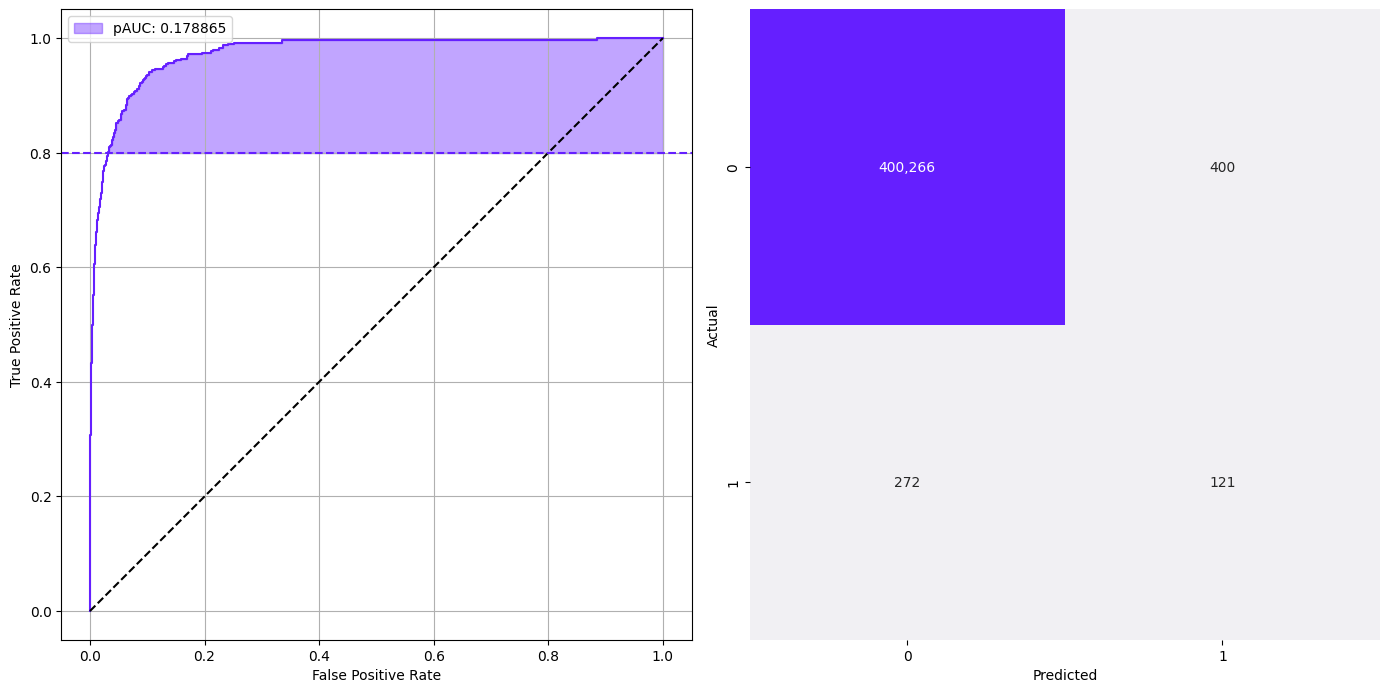

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, oof_pred_probs['Voting'][:, 1])
axes[0].plot(fpr, tpr, color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].fill_between(fpr, tpr, 0.8, where=(tpr >= 0.8), color='#651FFF', alpha=0.4, label=f'pAUC: {np.mean(voting_scores):.6f}')
axes[0].axhline(y=0.8, color='#651FFF', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = oof_pred_probs['Voting'].argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt=',', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

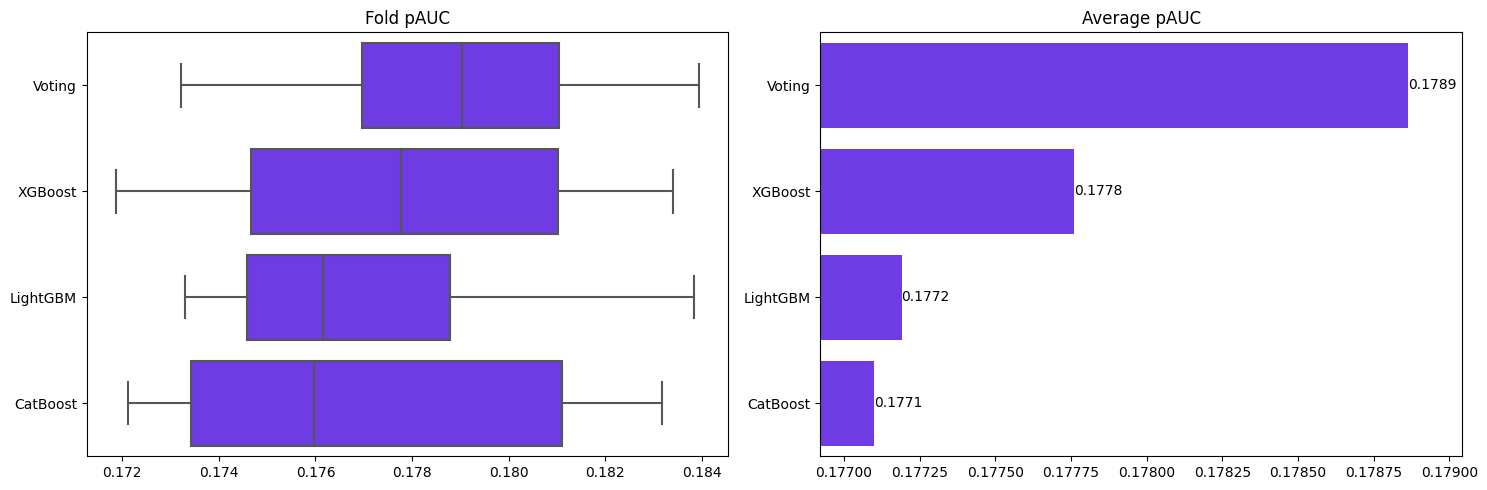

In [27]:
paucs = pd.DataFrame(paucs)
mean_paucs = paucs.mean().sort_values(ascending=False)
order = paucs.mean().sort_values(ascending=False).index.tolist()

min_pauc = mean_paucs.min()
max_pauc = mean_paucs.max()
padding = (max_pauc - min_pauc) * 0.1
lower_limit = min_pauc - padding
upper_limit = max_pauc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=paucs, order=order, ax=axs[0], orient='h', color='#651FFF')
axs[0].set_title('Fold pAUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_paucs.values, y=mean_paucs.index, ax=axs[1], color='#651FFF')
axs[1].set_title('Average pAUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_paucs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

# Submission

In [28]:
sub = pd.read_csv('/kaggle/input/isic-2024-challenge/sample_submission.csv')
sub['isic_id'] = sub['isic_id']
sub[CFG.target] = test_pred_probs['Voting'][:, 1]
sub.to_csv('submission.csv', index=False)
sub.head()

,isic_id,target
0,ISIC_0015657,0.481692
1,ISIC_0015729,0.376869
2,ISIC_0015740,0.500724


In [29]:
shutil.rmtree('catboost_info')